# Adversarial Training!

[Towards Deep Learning Models Resistant to Adversarial Attacks](https://arxiv.org/abs/1706.06083)

Introduce a dual optimization process (not guaranteed to increase robustness); fit network parameters $\theta$ so that 

$$
\min_\theta \mathbb{E}_{(x,y) \sim \mathcal{D}} \left[ \max_{\delta \in \mathcal{S}} L(\theta, x+\delta, y) \right]
$$

where $\mathcal{S}$ is the box around the input images $(x, y) \sim \mathcal{D}$ where we want to avoid for adversarial attacks (in this case, we'll use the infinity box),  and $L$ is a kind of attack metric that we want to increase (we'll be using PGD to increase the cross entropy loss).

In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np
import time 

from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device("cpu") # I'm not sure if it will work out of the box with cuda even if you have a GPU
torch.cuda.is_available()

False

In [3]:
def seed():
    np.random.seed(42)
    torch.manual_seed(42)

seed()

# Network

In [4]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(28*28, 200)
        self.fc2 = nn.Linear(200, 10)
        
    def forward(self, x):
        x = x.view((-1, 28*28))
        x = F.relu(self.fc(x))
        x = self.fc2(x)
        return x

# Data

In [5]:
batch_size = 64

In [6]:
train_dataset = datasets.MNIST(
    'mnist_data/', train=True, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

test_dataset = datasets.MNIST(
    'mnist_data/', train=False, download=True, transform=transforms.Compose(
    [transforms.ToTensor()]
))

In [7]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

In [22]:
class Normalize(nn.Module):
    def forward(self, x):
        return (x - 0.1307)/0.3081 # expectation and standard deviation

# Attack

There is one difference now compared to the attacking notebook: before the attack, the image is displaced a to a random location within the infinity ball of radius eps around the input image. This makes it possible for the attack to find more local minimia within the infinity ball, and thus enables a better defence.

In [9]:
def pgd_untargeted(
    model, 
    x, 
    labels, 
    k, 
    epsilon, 
    epsilon_step, 
    clamp_min=None, 
    clamp_max=None,
    **kwargs
):
    """Attack for adversarial training. Modifies input within infinity ball
    
        labels - true label
        k - attack iterations
        epsilon - |x - out| <= epsilon
        epsilon_step - step size
        clamps - are allowed range on image feature
    """
    x_min = x - epsilon
    x_max = x + epsilon
    
    img = torch.as_tensor(x, device=device)
    img += epsilon * torch.rand_like(img)
    img.requires_grad = True
    
    for i in range(k):
        model.zero_grad()
        nn.CrossEntropyLoss()(model(img), labels).backward()
        img = img + (epsilon_step * img.grad.sign())
        img = torch.min(x_max, torch.max(x_min, img))
        
        img = torch.as_tensor(img.data, device=device)
        img.requires_grad = True
        
    return img.clamp(clamp_min, clamp_max) if not clamp_min is None else img

# Fit

In [19]:
# Would be interesting to test different values 
# Plot accurace with and without attack and training

DEFAULT_ATTACK_KWARGS = {
    'k': 5, 
    'epsilon': 0.2,          
    'epsilon_step': 0.05,
    'clip_min': 0,
    'clip_max': 1,
}

def fit(
    model,
    learning_rate=0.0001,
    num_epochs=5,
    attack_kwargs=DEFAULT_ATTACK_KWARGS.copy()
):
    opt = optim.Adam(params=model.parameters(), lr=learning_rate)
    ce_loss = nn.CrossEntropyLoss()
    
    for epoch in range(num_epochs):
        model.train()
        t1 = time.time()

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            if attack_kwargs is not None:
                model.eval()
                x_batch = pgd_untargeted(model, x_batch, y_batch, **attack_kwargs)
                model.train()

            opt.zero_grad()
            out = model(x_batch)
            batch_loss = ce_loss(out, y_batch)
            batch_loss.backward()
            opt.step()

        tested_count, correct_count = 0.0, 0.0
        model.eval()
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            out = model(x_batch)
            pred = torch.max(out, dim=1)[1]
            acc = pred.eq(y_batch).sum().item()
            correct_count += acc
            tested_count += x_batch.size()[0]

        t2 = time.time()

        print('Epoch %d: Accuracy %.5lf [%.2lf seconds]' % (epoch+1, correct_count/tested_count, t2-t1))

In [20]:
seed()
model = nn.Sequential(Normalize(), Net()).to(device)
fit(model, attack_kwargs=None)

Epoch 1: Accuracy 0.91770 [7.50 seconds]
Epoch 2: Accuracy 0.93580 [7.90 seconds]
Epoch 3: Accuracy 0.94740 [8.03 seconds]
Epoch 4: Accuracy 0.95440 [8.07 seconds]
Epoch 5: Accuracy 0.95870 [8.09 seconds]


In [21]:
seed()
pgdmodel = nn.Sequential(Normalize(), Net()).to(device)
fit(pgdmodel)

Epoch 1: Accuracy 0.74430 [16.27 seconds]
Epoch 2: Accuracy 0.85380 [16.77 seconds]
Epoch 3: Accuracy 0.89360 [17.59 seconds]
Epoch 4: Accuracy 0.91340 [19.51 seconds]
Epoch 5: Accuracy 0.92130 [17.67 seconds]


# Is the robustness increased? Yes it is! :)

In [29]:
x, y = next(iter(train_loader))

out = model(x)

out.shape

torch.Size([64, 10])

In [37]:
k = 5
epsilon = 0.2
epsilon_step = 0.05

def accuracy_under_attack(
    model,
    data_loader,
    attack
):
    model.eval()
    tot_test, tot_acc = 0.0, 0.0
    for x_batch, y_batch in data_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        if attack:
            x_batch = pgd_untargeted(
                model,
                x_batch,
                y_batch,
                clip_min=0,
                clip_max=1,
                k=k,
                epsilon=epsilon,
                epsilon_step=epsilon_step,
            )
        
        out = model(x_batch)
        pred = torch.max(out, dim=1)[1]
        
        tot_acc += pred.eq(y_batch).sum().item()
        tot_test += x_batch.size()[0]
        
    return tot_acc/tot_test

In [49]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=124, shuffle=False)

df = pd.DataFrame(columns=['Net', 'Natural', 'PGD attack'])
df.loc[len(df), :] = ('Vanilla net',
        accuracy_under_attack(model, test_loader, False),
        accuracy_under_attack(model, test_loader,  True)
)

df.loc[len(df), :] = ('PGD trained',
        accuracy_under_attack(pgdmodel, test_loader, False),
        accuracy_under_attack(pgdmodel, test_loader,  True)
)

df = 100*df.set_index('Net')
df[' '] = "%"

### The Adversarially trained network performs better under attack

In [51]:
df

,Natural,PGD attack,
Net,,,
Vanilla net,95.87,0.05,%
PGD trained,92.13,55.89,%


## Loss distribution: The loss is more tightly concentrated around zero for adversarially trained networks

In [73]:
number_of_attacks = int(1e4)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

x, y = next(iter(test_loader))
x = torch.cat([torch.as_tensor(x) for i in range(number_of_attacks)], 0).to(device)
y = torch.cat([torch.as_tensor(y) for i in range(number_of_attacks)], 0).to(device)

advx = pgd_untargeted(model, x, y, 5, 0.2, 0.05, 0, 1)
ce_loss = torch.nn.CrossEntropyLoss(reduction='none')

loss = ce_loss(model(advx), y).cpu().detach().numpy()
advloss = ce_loss(pgdmodel(advx), y).cpu().detach().numpy()

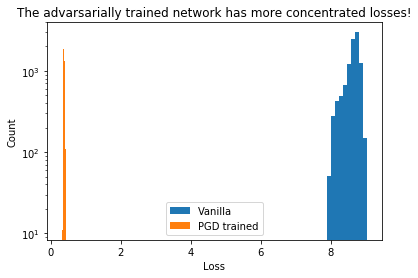

In [75]:
f, ax = plt.subplots()

ax.hist(loss, label="Vanilla")
ax.hist(advloss, label="PGD trained")

ax.legend(loc='best')
ax.set_yscale('log')

ax.set_xlabel('Loss')
ax.set_ylabel('Count')

plt.title("The advarsarially trained network has more concentrated losses!")
plt.show()